![](../images/logos.jpg "MiCMOR, KIT Campus Alpin")

**[MiCMOR](https://micmor.kit.edu) [SummerSchool "Environmental Data Science: From Data Exploration to Deep Learning"](https://micmor.kit.edu/sites/default/files/MICMoR%20Summer%20School%202019%20Flyer.pdf)**  
IMK-IFU KIT Campus Alpin, Sept. 4 - 13 2019, Garmisch-Partenkirchen, Germany.

---

# Working with PCA: Constructing the Multivariate ENSO Index

![](https://esdynamics.geo.uni-tuebingen.de/climstat/_images/MEI.jpg)

The El Nino Southern Oscillation directly and indirectly controls much of regional climates elsewhere. A common challenge in climatology is creating a time series that describes the intensity of such large scale atmospheric phenomenon. The Multivariate ENSO index is constructed with a multivariate EOF analysis applied to bi-monthly means of several atmospheric variables. (Note that atmospheric scientists use the term "Empirical Orthogonal Functions" to refer to a big PCA.)


## Multivariate ENSO Index
The MEI is calculated with a multivariate EOF Analysis using  Era Interim data 
for sea level pressure, sea surface temperatures, and zonal and meridional
near surface wind speeds for the region 30°S-30°N and 100°E-70°W.

The EOF is calculated for 12 bi-monthly, overlapping seasons. The result is an
index time series and loading pattern for the first EOF 

*Note:* Because of the large size of the covariance matrix, the `eof` package was used (for the analysis
https://ajdawson.github.io/eofs/latest/index.html).


In [1]:
# we do need another package that's not on the virtual machine
# please do the following:
# - open a new terminal in juyter
# - type: sudo su
# - type: pip3 install eofs

In [145]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [614]:
import numpy as np
from eofs.multivariate.standard import MultivariateEof
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

## Data loading

Let's start with loading the data, cutting out the region of interest and bringing everything into shape:

In [618]:
# copy the files into datasets with gsutil if they do not yet exist there...
# gsutil -m cp -r gs://eds-2019-datasets-chile ../datasets
! ls -l ../datasets/eds-2019-datasets-chile/era_interim/

total 918336
-rw-r--r--  1 werner-ch  901  106441092 Sep  7 19:59 msl_monthlync.nc
-rw-r--r--  1 werner-ch  901  108513604 Sep  7 19:58 sst_monthlync.sec
-rw-r--r--  1 werner-ch  901  106209660 Sep  7 19:59 u10_monthlync.sec
-rw-r--r--  1 werner-ch  901  106209660 Sep  7 19:59 v10_monthlync.sec


In [620]:
# datalocation and filenames
dpath = '../datasets/eds-2019-datasets-chile/era_interim'

fnames = ['msl_monthlync.nc', 'sst_monthlync.sec', 'u10_monthlync.sec', 'v10_monthlync.sec']
files = [f'{dpath}/{fname}' for fname in fnames]

*Note*: We have to load the dask arrays as they do have different time axis stamps. Otherwise we would simply load the with `open_mfdataset()`.

In [620]:
ds1 = xr.open_dataset(files[0]).sel(longitude=slice(134,334), latitude=slice(30,-30))
ds2 = xr.open_dataset(files[1]).sel(longitude=slice(134,334), latitude=slice(30,-30))
ds3 = xr.open_dataset(files[2]).sel(longitude=slice(134,334), latitude=slice(30,-30))
ds4 = xr.open_dataset(files[3]).sel(longitude=slice(134,334), latitude=slice(30,-30))

# time series are different, we need to find the minimum duration
common_steps = min([len(x.time.values) for x in [ds1, ds2, ds3, ds4]])

We now create a clean new dataset where we add all 4 sources with a common coordinate set. Thus, we can compute between the variables...



In [620]:
ds = xr.Dataset()

dims= ['time', 'latitude', 'longitude']

ds['msl'] = ds1.msl.isel(time=slice(0, common_steps))
# set empty dataarrays with right size
ds['sst'] = xr.full_like(ds.msl, None)
ds['u10'] = xr.full_like(ds.msl, None)
ds['v10'] = xr.full_like(ds.msl, None)

We now only pass the numpy arrays of the orginal files and thus retain the matching coordinates we just defined with `full_like`.

In [620]:
ds['sst'][:] = ds2.sst.isel(time=slice(0, common_steps)).values
ds['u10'][:] = ds3.u10.isel(time=slice(0, common_steps)).values
ds['v10'][:] = ds4.v10.isel(time=slice(0, common_steps)).values

In [621]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 267, time: 459)
Coordinates:
  * longitude  (longitude) float32 134.25 135.0 135.75 ... 332.25 333.0 333.75
  * latitude   (latitude) float32 30.0 29.25 28.5 27.75 ... -28.5 -29.25 -30.0
  * time       (time) datetime64[ns] 1979-01-16T09:00:00 ... 2017-03-16T09:00:00
Data variables:
    msl        (time, latitude, longitude) float32 101938.14 ... 101636.47
    sst        (time, latitude, longitude) float32 293.8322 ... 298.5476
    u10        (time, latitude, longitude) float32 2.5605602 ... -0.7300148
    v10        (time, latitude, longitude) float32 -2.3703823 ... -0.22578049

In [767]:
# delete unnecessary vars/ coordinates
del ds['time_bnds']
ds = ds.sortby('latitude')

KeyError: 'time_bnds'

If we want to transfer the longitude coords to -180,180 we could transform like the following lines:
    
```python
ds.coords['longitude'] = (ds.coords['longitude'] + 180) % 360 - 180
ds2 = ds.sortby(ds.longitude)
```

However, since we work on the pacific region we will keep the data as is...


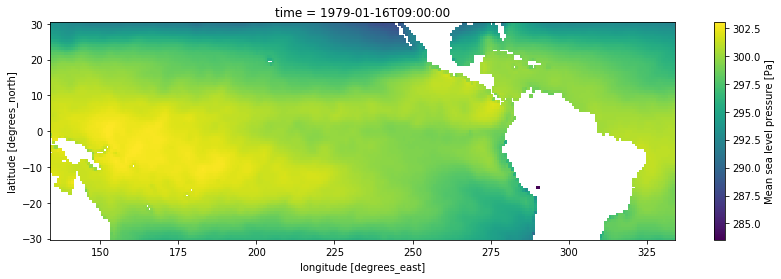

In [739]:
ds_region = ds.sel(longitude=slice(134,334), latitude=slice(-30,30)).load()
ds_region.isel(time=0).sst.plot(figsize=(14,4));

In [740]:
# rolling mean for two time values, default rolling function not working
for d in ds_region.data_vars:
    ds_region[d][:-1] = ds_region[d].values[:-1] * 0.5 + ds_region[d].values[1:] * 0.5

In [741]:
ds_region = ds_region.isel(time=slice(0,38*12))

In [742]:
# we compute the mean and std
ds_bm_mean = ds_region.groupby('time.month').mean(dim='time')
ds_bm_std = ds_region.groupby('time.month').std(dim='time')

/Users/werner-ch/.pyenv/versions/3.7.3/envs/ds-default/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/werner-ch/.pyenv/versions/3.7.3/envs/ds-default/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


And finally, we compute the anomalies with some nice `xarray` apply magick! 🤘

In [769]:
ds_anomalies = xr.apply_ufunc(lambda x, m, s: (x - m) / s,
                              ds_region.groupby('time.month'),
                              ds_bm_mean, ds_bm_std, dask='allowed').load()

In [770]:
ds_anomalies

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 267, time: 456)
Coordinates:
  * longitude  (longitude) float64 134.2 135.0 135.8 136.5 ... 332.2 333.0 333.8
  * latitude   (latitude) float64 -30.0 -29.25 -28.5 -27.75 ... 28.5 29.25 30.0
  * time       (time) datetime64[ns] 1979-01-16T09:00:00 ... 2016-12-16T09:00:00
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    msl        (time, latitude, longitude) float32 -1.6480143 ... 0.25652236
    sst        (time, latitude, longitude) float32 nan nan ... 0.8367048
    u10        (time, latitude, longitude) float32 -0.60493004 ... -0.030975478
    v10        (time, latitude, longitude) float32 -1.5113536 ... -0.7291733

In [771]:
# delete anomalies month var, as it's not needed
del ds_anomalies['month']

We now perform the actual EOF and record the results for all seasons. Since eof currently does not provide the MultivariateEOF for the xarray interface we compute on the numpy arrays contained in the xarray types and convert them back to an result xarray afterwards...

In [746]:
eofs = []
pcs = []
vfracs = []

# for each bi-monthly season
for m, g in ds_anomalies.load().groupby('time.month'):
    
    # eof unfortunately currently does not have a MultivariateEof for 
    # xarrays so we use ndarrays (numpy)
    dataset = [g.msl.values, g.sst.values, g.u10.values, g.v10.values]
    
    solver = MultivariateEof(dataset, center=False)

    # now we convert the result back to xarrays

    eof1_results = solver.eofsAsCovariance(neofs=1)
    
    eof1 = xr.full_like(g.isel(time=0), None)
    
    for i, v in enumerate(['msl','sst','u10','v10']):
        eof1[v] = (['latitude', 'longitude'], eof1_results[i].squeeze())
    eofs.append(eof1)
            
    pc1 = solver.pcs(npcs=1, pcscaling=1)    
    pcs.append(pc1.flatten())

    var_frac1 = solver.varianceFraction(neigs=1)
    vfracs.append(var_frac1[0])

# create xarrays again
eof_mv = xr.concat(eofs, dim='month')

In [772]:
# stack pcs from 2d to 3d
pcs = np.stack(pcs)
pcs_mv = xr.DataArray(np.array(pcs), coords=[('month', range(1,13)), ('year', range(1979,2017))])
pcs_mv

<xarray.DataArray (month: 12, year: 38)>
array([[-2.186437e-01, -7.534035e-01, -1.655121e-01, ...,  3.002546e-01,
         1.294787e-03, -1.137593e+00],
       [-3.902828e-01, -9.414278e-01, -4.513858e-02, ...,  3.882822e-01,
        -2.695057e-01, -1.007829e+00],
       [-3.082789e-01, -1.013495e+00,  2.418657e-01, ...,  2.166251e-01,
        -1.229789e+00, -4.012059e-01],
       ...,
       [-7.110696e-01,  5.620874e-02,  2.458406e-01, ..., -3.558860e-01,
        -1.771410e+00,  1.382484e-01],
       [-6.709849e-01,  7.608976e-03,  2.699992e-01, ..., -2.734283e-01,
        -1.593832e+00,  1.910697e-01],
       [-6.815691e-01, -1.156109e-01,  2.237752e-01, ..., -1.132923e-01,
        -1.317923e+00,  3.211529e-01]], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2012 2013 2014 2015 2016

# Result plots

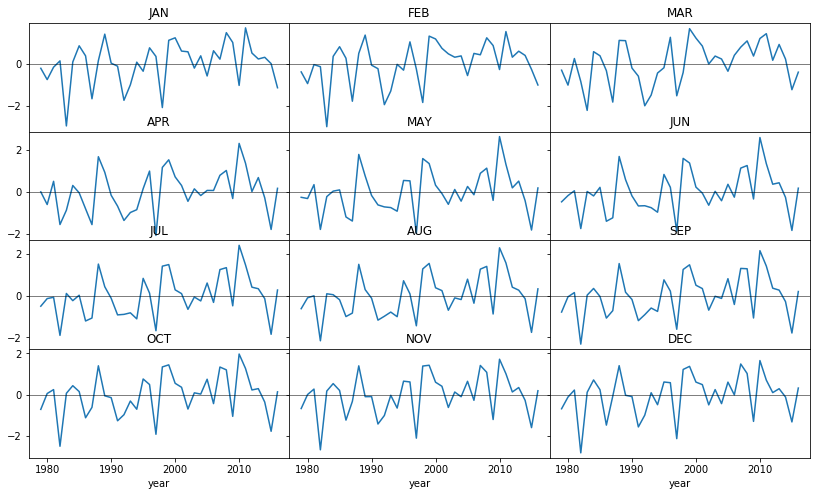

In [773]:
fig, axes = plt.subplots(4, 3, figsize=(14,8), sharex='col', sharey='row') # sharex=True, sharey=True)

month_names = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

for m, ax in enumerate(axes.flat):
    pcs_mv.sel(month=m+1).plot(ax=ax)
    ax.axhline(0, color='k', lw=.5)
    ax.set_title(f'{month_names[m]}')
  
plt.subplots_adjust(wspace=0, hspace=0)

We now transform the `xarray dataarray` to a `pandas dataframe`, then we go from wide to long format with `melt`.

In [774]:
df = pcs_mv.to_pandas().reset_index().melt(id_vars='month')
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=15))
df = df.set_index('date').sort_index()

## ENSO anomalies

Text(0.5, 1.0, 'MEI: Multivariate Solver')

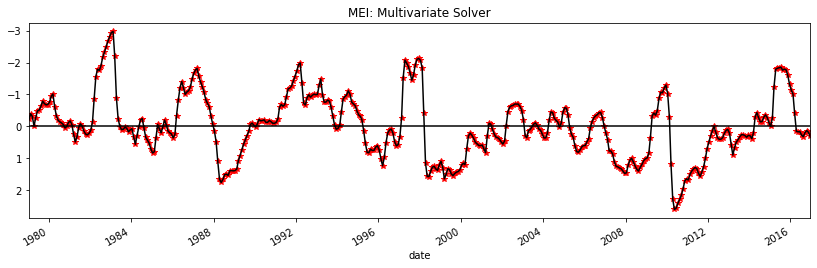

In [775]:
p = df.value.plot(style='r*', figsize=(14,4))
df.value.plot(style='k-', figsize=(14,4), ax=p)
plt.gca().invert_yaxis()
plt.axhline(0, color='k')
plt.title("MEI: Multivariate Solver")

##  Eof loading patterns for one of the seasons 

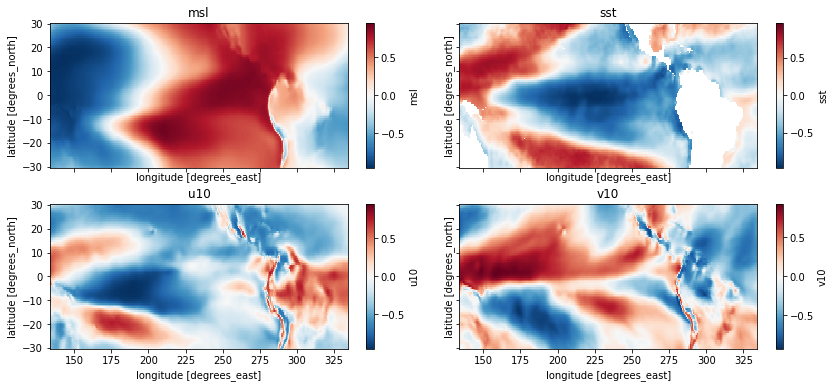

In [776]:
fig, axes = plt.subplots(2,2, figsize=(14,6), sharex=True, sharey=True)

for (i, ax), var in zip(enumerate(axes.flat), eof_mv.data_vars):
    eof_mv[var].sel(month=0).plot(ax=ax)
    ax.set_title(var)
plt.subplots_adjust(wspace=0.1, hspace=0.25)